## Neural Machine Translation for German-English on the Multi30K dataset

Multi30K is a dataset to stimulate multilingual multimodal research for English-German. It is based on the Flickr30k dataset, which contains 31,014 images sourced from online photo-sharing websites. Each image is paired with five English descriptions, which were collected from Amazon Mechanical Turk. The dataset contains 145,000 training, 5,070 development, and 5,000 test descriptions. The Multi30K dataset extends the Flickr30K dataset with translated and independent German sentences.

The baseline score is a Seq2Seq model with LSTM. Three approaches are then implemented to improve the translation quality:
* Learning rate decay
* Using CNN as encoder
* Using pre-trained word embedding

Translation quality is evaluated by BLEU score.

This notebook is based on the assignment from the course "Deep Learning in Applications" at Harbour.Space University.

In [2]:
import os

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Data processing

In [17]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [18]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [19]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'),
                                                   fields=(SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████████████████| 1.21M/1.21M [00:08<00:00, 136kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|███████████████████| 46.3k/46.3k [00:00<00:00, 60.7kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|███████████| 66.2k/66.2k [00:01<00:00, 54.5kB/s]


In [20]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


We'll only keep the tokens that occur minimum 5 times.

In [21]:
MIN_FREQ_SRC = 5
MIN_FREQ_TRG = 5

In [22]:
SRC.build_vocab(train_data, min_freq = MIN_FREQ_SRC)
TRG.build_vocab(train_data, min_freq = MIN_FREQ_TRG)

In [23]:
print(f"Unique tokens in source vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (EN) vocabulary: {len(TRG.vocab)}")

Unique tokens in source vocabulary: 3591
Unique tokens in target (EN) vocabulary: 3274


Here are some tokens from original corpus (DE):

In [24]:
SRC.vocab.itos[::100]

['<unk>',
 'gelben',
 'sonnenbrille',
 'ihrer',
 'alte',
 'führen',
 'computer',
 'fahrrädern',
 'hula',
 'dunkelhäutige',
 'sitzender',
 'becher',
 'ich',
 'kariertem',
 'fahne',
 'näht',
 'ruhigen',
 'ansieht',
 'welpe',
 'serviert',
 'krankenhaus',
 'beachvolleyball',
 'musikinstrumente',
 'betonmauer',
 'of',
 'zuhause',
 'habseligkeiten',
 'regnet',
 'aquarium',
 'gehoben',
 'nachtclub',
 'trenchcoat',
 'bergsteigen',
 'großem',
 'müde',
 'sprache']

From target (EN) corpus:

In [25]:
TRG.vocab.itos[::200]

['<unk>',
 'under',
 'parade',
 'drinks',
 'catching',
 'pot',
 'obstacle',
 '!',
 'teammate',
 'loom',
 'cop',
 'rifle',
 'too',
 'squats',
 'overlook',
 'comforting',
 'smooth']

Some examples from the train dataset:

In [26]:
print(vars(train_data.examples[9]))

{'src': ['jungen', 'tanzen', 'mitten', 'in', 'der', 'nacht', 'auf', 'pfosten', '.'], 'trg': ['boys', 'dancing', 'on', 'poles', 'in', 'the', 'middle', 'of', 'the', 'night', '.']}


Let's check the length distributions:

Length distribution in Train data


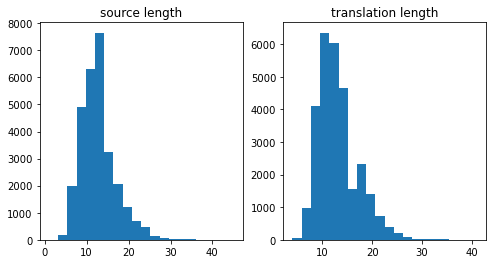

In [27]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


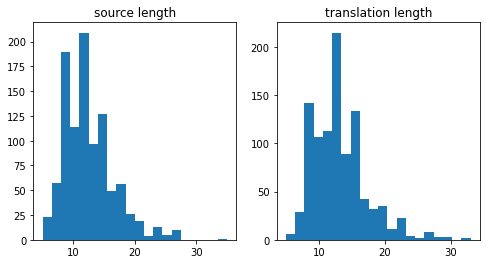

In [28]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

## Building the baseline model

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [32]:
device

device(type='cpu')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 256

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 256 from MULTI30K]
	[.src]:[torch.cuda.LongTensor of size 31x256 (GPU 0)]
	[.trg]:[torch.cuda.LongTensor of size 31x256 (GPU 0)]
torch.Size([31, 256]) torch.Size([31, 256])


In [29]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [33]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [34]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3591, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3274, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=3274, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,793,418 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
                ax[1].set_xlabel('Epoch')
                ax[1].set_title('Validation BLEU')
            # if train_history is not None:
            #     ax[1].plot(train_history, label='general train history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluateBLEU(model, iterator):
    from nltk.translate.bleu_score import corpus_bleu
    import utils
    import imp
    imp.reload(utils)
    generate_translation = utils.generate_translation
    remove_tech_tokens = utils.remove_tech_tokens
    get_text = utils.get_text
    flatten = utils.flatten

    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.argmax(dim=-1)

            original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])
    return corpus_bleu([[text] for text in original_text], generated_text) * 100

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_history_baseline = []
valid_history_baseline = []

N_EPOCHS = 60
CLIP = 1

# best_valid_loss = float('inf')
best_valid_BLEU = 0

In [ ]:
!mkdir drive/MyDrive/DLiA-HW2

mkdir: cannot create directory ‘drive/MyDrive/DLiA-HW2’: File exists


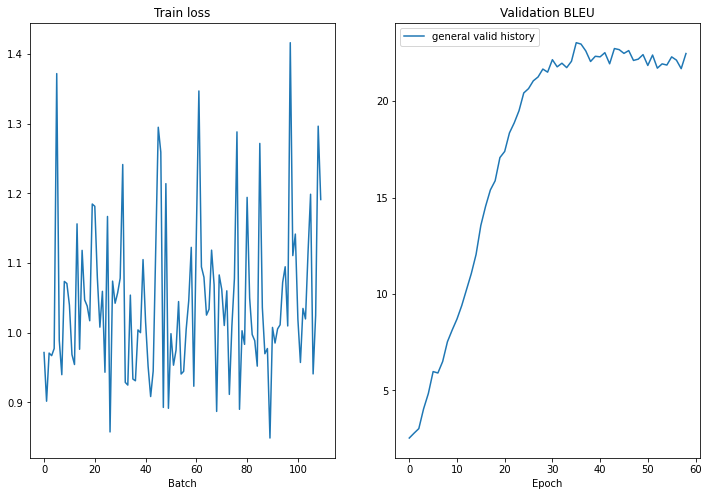

Epoch: 60 | Time: 0m 29s
	Train Loss: 1.045 | Train PPL:   2.843
	 Val. BLEU: 22.051 |  Val. PPL: 3773250001.962


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history_baseline, valid_history_baseline)
    valid_BLEU = evaluateBLEU(model, valid_iterator)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_BLEU > best_valid_BLEU:
        best_valid_BLEU = valid_BLEU
        torch.save(model.state_dict(), 'baseline-model.pt')
    
    train_history_baseline.append(train_loss)
    valid_history_baseline.append(valid_BLEU)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. BLEU: {valid_BLEU:.3f} |  Val. PPL: {math.exp(valid_BLEU):7.3f}')

In [ ]:
import pickle

In [ ]:
with open('train_history_baseline.pkl', "wb") as output_file:
    pickle.dump(train_history_baseline, output_file)
with open('valid_history_baseline.pkl', "wb") as outout_file:
    pickle.dump(valid_history_baseline, output_file)

__Let's take a look at our network quality__:

In [ ]:
model.load_state_dict(torch.load('baseline-model.pt'))

<All keys matched successfully>

In [36]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

Take a look at the example translation:

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
import numpy as np

In [ ]:
for idx in np.arange(3):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: a man throws a fishing net into the .
Generated: a man is throwing a fishing rod into the end .

Original: a yellow bulldozer working to move dirt .
Generated: a yellow car the of the .

Original: children ride bikes in what appears to be an .
Generated: kids in a line , doing a in .



In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

4it [00:00, 10.04it/s]


### Baseline score:

In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

23.230268857093492

## Method 1: Learning rate decay:

In [ ]:
# Re-initiate the model
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model_lr_decay = Seq2Seq(enc, dec, device).to(device)
model_lr_decay.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3591, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3274, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=3274, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
from torch.optim.lr_scheduler import StepLR

From the training plot, the model stopped training after around 20 epochs, therefore I'll multiply learning rate by 0.1 after 20 epochs.

In [ ]:
optimizer = optim.Adam(model_lr_decay.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
# Add lr step scheduler
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

In [ ]:
train_history_lr_decay = []
valid_history_lr_decay = []

N_EPOCHS = 60
CLIP = 1
best_valid_BLEU = 0

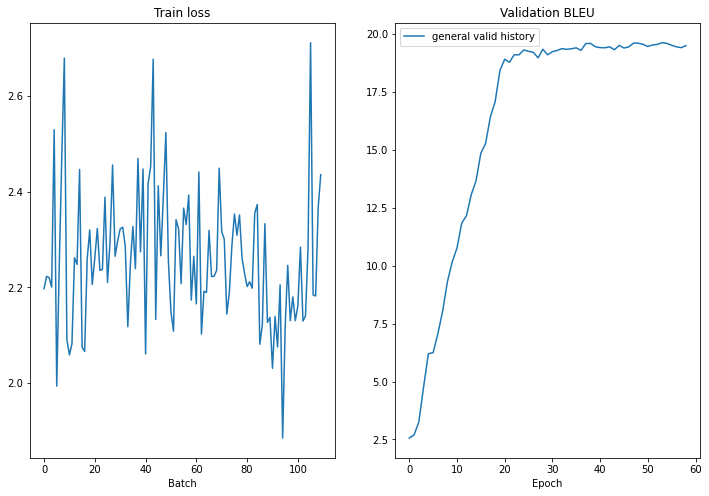

Epoch: 60 | Time: 0m 29s
	Train Loss: 2.263 | Train PPL:   9.610
	 Val. BLEU: 19.327 |  Val. PPL: 247553600.722


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_lr_decay, train_iterator, optimizer, criterion, CLIP, train_history_lr_decay, valid_history_lr_decay)
    valid_BLEU = evaluateBLEU(model_lr_decay, valid_iterator)
    scheduler.step()
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_BLEU > best_valid_BLEU:
        best_valid_BLEU = valid_BLEU
        torch.save(model_lr_decay.state_dict(), 'lr-decay-model.pt')
    
    train_history_lr_decay.append(train_loss)
    valid_history_lr_decay.append(valid_BLEU)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. BLEU: {valid_BLEU:.3f} |  Val. PPL: {math.exp(valid_BLEU):7.3f}')

In [ ]:
with open('train_history_lr_decay.pkl', "wb") as output_file:
    pickle.dump(train_history_lr_decay, output_file)
with open('valid_history_lr_decay.pkl', "wb") as output_file:
    pickle.dump(valid_history_lr_decay, output_file)

#### Evaluate the model:

In [ ]:
model_lr_decay.load_state_dict(torch.load('lr-decay-model.pt'))

<All keys matched successfully>

In [ ]:
original_text = []
generated_text = []
model_lr_decay.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model_lr_decay(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

4it [00:00, 11.23it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

19.61126814064022

In [ ]:
with open('valid_history_baseline.pkl', 'rb') as file:
    valid_history_baseline = pickle.load(file)
with open('valid_history_lr_decay.pkl', 'rb') as file:
    valid_history_lr_decay = pickle.load(file)

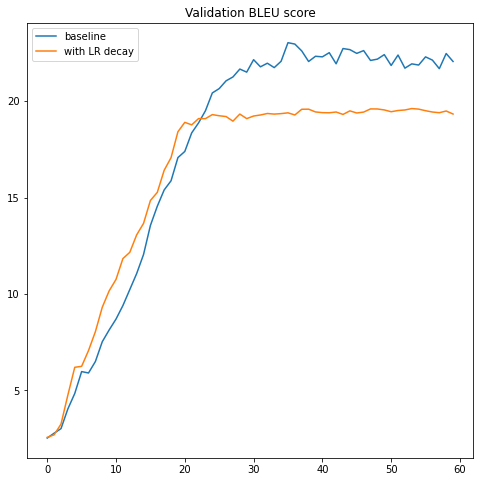

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.plot(valid_history_baseline, label='baseline')
ax.plot(valid_history_lr_decay, label='with LR decay')
ax.set_title('Validation BLEU score')
plt.legend()

The sudden decrease in learning rate stopped the model from training even earlier than baseline. I'll experiment again with a smaller decay.

In [ ]:
# Re-initiate the model
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model_lr_decay_2 = Seq2Seq(enc, dec, device).to(device)
model_lr_decay_2.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3591, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3274, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=3274, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
optimizer = optim.Adam(model_lr_decay_2.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
# Add lr step scheduler
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

In [ ]:
train_history_lr_decay_2 = []
valid_history_lr_decay_2 = []

N_EPOCHS = 60
CLIP = 1
best_valid_BLEU = 0

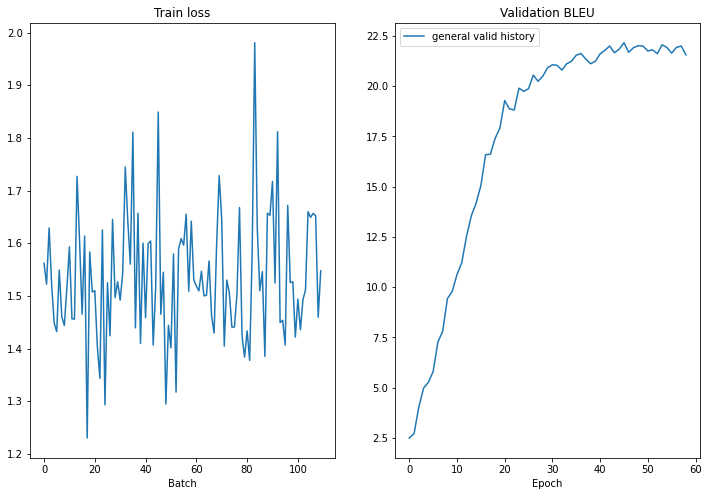

Epoch: 60 | Time: 0m 29s
	Train Loss: 1.535 | Train PPL:   4.642
	 Val. BLEU: 21.596 |  Val. PPL: 2393392596.123


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_lr_decay_2, train_iterator, optimizer, criterion, CLIP, train_history_lr_decay_2, valid_history_lr_decay_2)
    valid_BLEU = evaluateBLEU(model_lr_decay_2, valid_iterator)
    scheduler.step()
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_BLEU > best_valid_BLEU:
        best_valid_BLEU = valid_BLEU
        torch.save(model_lr_decay_2.state_dict(), 'lr-decay-model_2.pt')
    
    train_history_lr_decay_2.append(train_loss)
    valid_history_lr_decay_2.append(valid_BLEU)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. BLEU: {valid_BLEU:.3f} |  Val. PPL: {math.exp(valid_BLEU):7.3f}')

In [ ]:
with open('train_history_lr_decay_2.pkl', "wb") as output_file:
    pickle.dump(train_history_lr_decay_2, output_file)
with open('valid_history_lr_decay_2.pkl', "wb") as output_file:
    pickle.dump(valid_history_lr_decay_2, output_file)

### Evaluate the model:

In [ ]:
model_lr_decay_2.load_state_dict(torch.load('lr-decay-model_2.pt'))

<All keys matched successfully>

In [ ]:
original_text = []
generated_text = []
model_lr_decay_2.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model_lr_decay_2(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

4it [00:00, 10.59it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

22.327864321295102

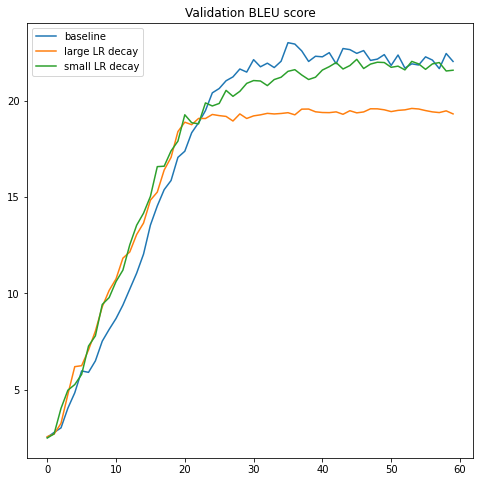

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.plot(valid_history_baseline, label='baseline')
ax.plot(valid_history_lr_decay, label='large LR decay')
ax.plot(valid_history_lr_decay_2, label='small LR decay')
ax.set_title('Validation BLEU score')
plt.legend()

The smaller decay rates performed better, but it still haven't beat the baseline yet. I think it may improve the result with longer training (100+ epochs)

## Method 2: CNN encoder

Below I'll write a new class for CNN encoder. In the previous model, the decoder takes the hidden and cell state from all the encoder RNN layers as input. Meanwhile, CNN is only capable of producing 1 output. Therefore, I'll use that CNN output as the hidden as well as cell state for all the decoder RNN layers.

In [37]:
class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((1, 2, 0))

class EncoderCNN(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(num_embeddings=input_dim, embedding_dim=emb_dim)

        self.cnn = nn.Sequential(
            Reorder(),
            nn.Conv1d(
                in_channels=emb_dim,
                out_channels=emb_dim*4,
                kernel_size=2
            ),
            nn.ReLU(),
            nn.Conv1d(
                in_channels=emb_dim*4,
                out_channels=emb_dim*4,
                kernel_size=3
            ),
            nn.BatchNorm1d(emb_dim*4),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
            nn.Linear(emb_dim*4, hid_dim)
        )

        # output shape: [batch size, hid_dim]
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        
        # Compute an embedding from the src data and apply dropout to it
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        
        output = self.cnn(embedded)
        # output shape: [batch size, hid_dim]

        # I'll use the above output as both hidden and cell state for all layers
        outputs = [output[None, :, :]] * self.n_layers # adding a new dimension for layers 
        hidden = torch.cat(outputs)
        cell = torch.cat(outputs)
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        return hidden, cell

In [38]:
enc = EncoderCNN(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model_CNN = Seq2Seq(enc, dec, device).to(device)
model_CNN.apply(init_weights)

Seq2Seq(
  (encoder): EncoderCNN(
    (embedding): Embedding(3591, 256)
    (cnn): Sequential(
      (0): Reorder()
      (1): Conv1d(256, 1024, kernel_size=(2,), stride=(1,))
      (2): ReLU()
      (3): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,))
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): AdaptiveMaxPool1d(output_size=1)
      (7): Flatten(start_dim=1, end_dim=-1)
      (8): Linear(in_features=1024, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3274, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=3274, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
optimizer = optim.Adam(model_CNN.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

train_history_cnn = []
valid_history_cnn = []

N_EPOCHS = 50
CLIP = 1

best_valid_BLEU = 0

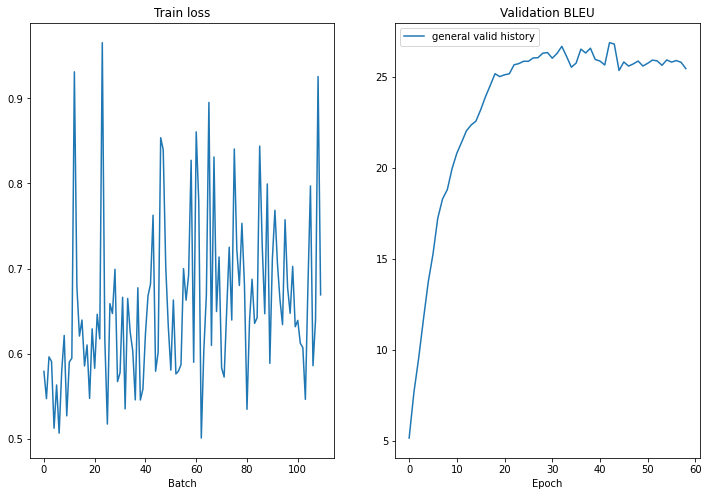

Epoch: 10 | Time: 0m 28s
	Train Loss: 0.660 | Train PPL:   1.935
	 Val. BLEU: 25.396 |  Val. PPL: 106975389578.788


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_CNN, train_iterator, optimizer, criterion, CLIP, train_history_cnn, valid_history_cnn)
    valid_BLEU = evaluateBLEU(model_CNN, valid_iterator)

    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_BLEU > best_valid_BLEU:
        best_valid_BLEU = valid_BLEU
        torch.save(model_CNN.state_dict(), 'CNN-model.pt')
    
    train_history_cnn.append(train_loss)
    valid_history_cnn.append(valid_BLEU)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. BLEU: {valid_BLEU:.3f} |  Val. PPL: {math.exp(valid_BLEU):7.3f}')

In [ ]:
with open('train_history_cnn.pkl', "wb") as output_file:
    pickle.dump(train_history_cnn, output_file)
with open('valid_history_cnn.pkl', "wb") as output_file:
    pickle.dump(valid_history_cnn, output_file)

### Evaluate the model:

In [ ]:
model_CNN.load_state_dict(torch.load('CNN-model.pt'))

<All keys matched successfully>

In [ ]:
original_text = []
generated_text = []
model_CNN.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model_CNN(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

4it [00:00, 10.75it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

26.437562103597017

## Method 3: Pre-trained word embedding

Download German embedding:

In [ ]:
!curl https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.de.300.bin.gz -o 'cc.de.300.bin.gz'
!gunzip 'cc.de.300.bin.gz'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4288M  100 4288M    0     0  48.4M      0  0:01:28  0:01:28 --:--:-- 51.6M


In [ ]:
from gensim.models.wrappers import FastText

In [ ]:
gensim_de = FastText.load_fasttext_format('cc.de.300.bin')

In [ ]:
weight_matrix_de = torch.zeros((INPUT_DIM, gensim_de.vector_size))
missing_words_de = []

for i in range(INPUT_DIM):
    try:
    weight_matrix_de[i] = torch.FloatTensor(gensim_de[SRC.vocab.itos[i]])
    except KeyError:
    weight_matrix_de[i] = torch.randn(gensim_de.vector_size)
    missing_words_de.append(SRC.vocab.itos[i])

In [ ]:
missing_words_de

['“.', '“-', '".', '.“']

In [ ]:
with open('weight_matrix_de.pkl', "wb") as output_file:
    pickle.dump(weight_matrix_de, output_file)

Download English embedding:

In [ ]:
!curl https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -o 'cc.en.300.bin.gz'
!gunzip 'cc.en.300.bin.gz'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4294M  100 4294M    0     0  48.8M      0  0:01:27  0:01:27 --:--:-- 46.0M


In [ ]:
gensim_en = FastText.load_fasttext_format('cc.en.300.bin')

In [ ]:
weight_matrix_en = torch.zeros((3274, gensim_en.vector_size))
missing_words_en = []

for i in range(3274):
    try:
    weight_matrix_en[i] = torch.FloatTensor(gensim_en[TRG.vocab.itos[i]])
    except KeyError:
    weight_matrix_en[i] = torch.randn(gensim_en.vector_size)
    missing_words_en.append(TRG.vocab.itos[i])

In [ ]:
missing_words_en

['".', '."', '",', '!"']

In [ ]:
with open('weight_matrix_en.pkl', "wb") as output_file:
    pickle.dump(weight_matrix_en, output_file)



---



---



In [ ]:
with open('weight_matrix_en.pkl', 'rb') as file:
    weight_matrix_en = pickle.load(file)
with open('weight_matrix_de.pkl', 'rb') as file:
    weight_matrix_de = pickle.load(file)

In [ ]:
class EncoderPretrained(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, dropout, pretrained_weight):
        super().__init__()
        
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
#         self.dropout = dropout
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_weight)
        self.embedding.requires_grad_(False)
        self.emb_dim = self.embedding.embedding_dim

        self.rnn = nn.LSTM(
            input_size=self.emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
            # <YOUR CODE HERE>
        
        self.dropout = nn.Dropout(p=dropout)# <YOUR CODE HERE>
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        
        # Compute an embedding from the src data and apply dropout to it
        embedded = self.embedding(src)# <YOUR CODE HERE>
        
        embedded = self.dropout(embedded)
        
        output, (hidden, cell) = self.rnn(embedded)
        #embedded = [src sent len, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        
        # <YOUR CODE HERE> 
        
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell
    

class DecoderPretrained(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, dropout, pretrained_weight):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_weight)
        self.embedding.requires_grad_(False)
        self.emb_dim = self.embedding.embedding_dim
        
        self.rnn = nn.LSTM(
            input_size=self.emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
            # <YOUR CODE HERE>
        
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )
            # <YOUR CODE HERE>
        
        self.dropout = nn.Dropout(p=dropout)# <YOUR CODE HERE>
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        # Compute an embedding from the input data and apply dropout to it
        embedded = self.dropout(self.embedding(input))# <YOUR CODE HERE>
        
        #embedded = [1, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        # <YOUR CODE HERE>
        
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #sent len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

Initialize model:

In [ ]:
enc = EncoderPretrained(INPUT_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, weight_matrix_de)
dec = DecoderPretrained(OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, weight_matrix_en)
model_pretrained = Seq2Seq(enc, dec, device).to(device)

In [ ]:
optimizer = optim.Adam(model_pretrained.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
train_history_pretrained = []
valid_history_pretrained = []

N_EPOCHS = 60
CLIP = 1

best_valid_BLEU = 0

Train model:


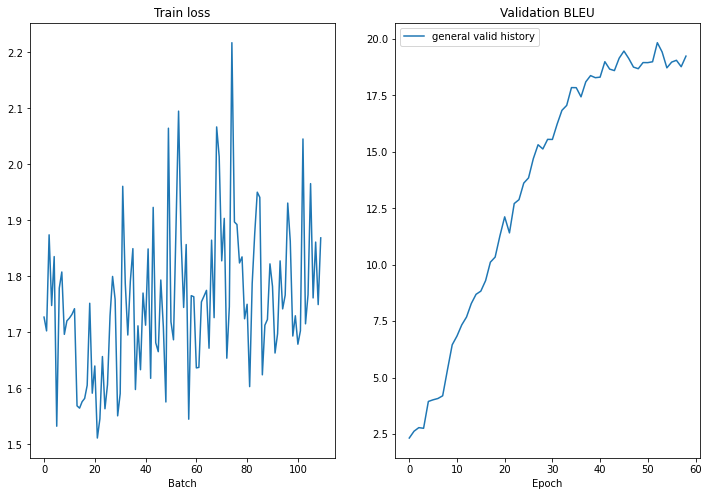

Epoch: 60 | Time: 0m 29s
	Train Loss: 1.761 | Train PPL:   5.818
	 Val. BLEU: 19.145 |  Val. PPL: 206373987.442


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_pretrained, train_iterator, optimizer, criterion, CLIP, train_history_pretrained, valid_history_pretrained)
    valid_BLEU = evaluateBLEU(model_pretrained, valid_iterator)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_BLEU > best_valid_BLEU:
        best_valid_BLEU = valid_BLEU
        torch.save(model_pretrained.state_dict(), 'model-pretrained.pt')
    
    train_history_pretrained.append(train_loss)
    valid_history_pretrained.append(valid_BLEU)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. BLEU: {valid_BLEU:.3f} |  Val. PPL: {math.exp(valid_BLEU):7.3f}')

In [ ]:
with open('train_history_pretrained.pkl', "wb") as output_file:
    pickle.dump(train_history_pretrained, output_file)
with open('valid_history_pretrained.pkl', "wb") as output_file:
    pickle.dump(valid_history_pretrained, output_file)

### Evaluate the model:

In [ ]:
model_pretrained.load_state_dict(torch.load('model-pretrained.pt'))

<All keys matched successfully>

In [ ]:
original_text = []
generated_text = []
model_pretrained.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model_pretrained(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

4it [00:00, 14.88it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

18.171111159218466

## Summary of the experiments:

Validation BLEU:

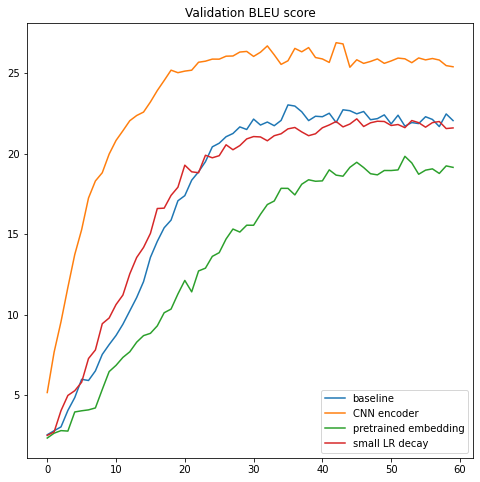

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.plot(valid_history_baseline, label='baseline')
ax.plot(valid_history_cnn, label='CNN encoder')
ax.plot(valid_history_pretrained, label='pretrained embedding')
ax.plot(valid_history_lr_decay_2, label='small LR decay')
ax.set_title('Validation BLEU score')
plt.legend()

BLEU score summary:

| Model                      | BLEU score |
|----------------------------|------------|
| Baseline                   | 23.23      |
| learning rate decay        | 22.32      |
| CNN encoder                | 26.44      |
| pre-trained word embedding | 18.17      |

Among all the methods implemented, the model with CNN encoder performed the best with an OK-ish score of 26.44. I believe with further experiments, there is still room for improvement:


*   Fine-tuning CNN architecture
*   Increase traning epochs, and apply learning rate decay at around epoch 50th
*   Fine-tune learning rate
*   Experiment with different optimizers, and learning rate decay methods.

Other options which may be implemented to improve the translation quality:
* Attention/self-attention mechanism
* Pretraining the language model
* Byte Pair Encoding
* Fine-tunning BERT
